# Ridge regression (l2 regularization) three ways

This notebook seeks to implement ridge regression (linear regression with l2 regularization) in three ways: <br>
- sci-kit learn implementation <br>
- normal equation implementation - using numpy arrays<br>
- gradient descent implementation - using numpy arrays <br>
<br>
It uses the whole of the Boston house-price dataset.

The setup for ridge regression is:
<br>
<br>
$Hypothesis: h(x) = \sum_{j=1}^{n}\theta_jx_j$
<br>
<br>
$Cost: J(\theta) = \frac{1}{2m}[\sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 + \lambda\sum_{j=1}^{n}\theta_j^2]$

Intuitively ridge regression shrinks the coefficients by penalizing their size. The $\lambda$ regularization term controls the amount of this shrinkage.

# Import libraries

Load the libraries needed for the notebook

In [1]:
import numpy as np
from sklearn import datasets
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Setup chart settings

In [2]:
# plot charts automatically
%matplotlib inline
# define plot styles
sns.set(font_scale=2)
sns.set_style("darkgrid")

# Import datasets

Load and return the Boston house-prices dataset (regression).

In [3]:
# import Boston dataset from sklearn and create X features and y vector
boston = datasets.load_boston()
y = boston.target
X = boston.data

Scale data as this is needed for regularization and gradient descent

In [4]:
# Initiate the standard scaler: scaler
scaler = StandardScaler()
# Scale data as feature scaling makes gradient descent/ regularization converge more quickly or converge at all
X = scaler.fit_transform(X)

Check the format of the data

In [5]:
# check the shape of the data
print(y.shape,X.shape)

(506,) (506, 13)


# Assign constants and set print conditions

Assign constants for the models

In [6]:
# assign lambda for regularization term
regularization=0.5
# assign random state
random_state=42

Set print formats so that numpy arrays do not print in scientific format

In [7]:
# Set print conditions
np.set_printoptions(suppress=True, precision=2) 

# Regression

### Sci-kit learn baseline

Sci-kit learn's implementation of linear least squares with l2 regularization.

In [8]:
# Create the linear regression with ridge regressor (l2 regularization): lr_ridge
lr_ridge = linear_model.Ridge(alpha=regularization, random_state=random_state)

In [9]:
# Fit the model to the data: model_ridge
model_ridge = lr_ridge.fit(X,y)

In [10]:
# Compute predictions for the features: y_pred_ridge
y_pred_ridge = model_ridge.predict(X)

In [11]:
# print intercept:
print("Intercept: ",model_ridge.intercept_)

Intercept:  22.5328063241


In [12]:
# print coefficients
print("Coefficients: ",model_ridge.coef_)

Coefficients:  [-0.92  1.07  0.13  0.68 -2.05  2.67  0.02 -3.09  2.62 -2.04 -2.06  0.86
 -3.74]


In [13]:
# print the mean squared error:
print("Mean squared error: ",mean_squared_error(y,y_pred_ridge))

Mean squared error:  21.8980429263


### Normal equation

Next an implementation of ridge regression via the closed-form solution (analytical solution) below. Note that the form of the L matrix ensures that the regularization is not applied to the intercept term (the upper left term is zero).
<br>
<br>
$
\begin{align}
\theta = (X^TX+\lambda.L)^{-1}X^Ty
\end{align}
$
<br>
<br>
where $
  L =
  \begin{bmatrix}
    0 & & & & &\\
    & 1 & & & &\\
    & & 1 & & &\\
    & & & \ddots & & \\
    & & & & & 1
  \end{bmatrix}$

In [14]:
# Add column of 1s to feature matrix, which is needed for the matrix implementation of the normal equation and gradient descent
X = np.hstack((np.ones((X.shape[0], 1)),X))

In [15]:
# initialize the matrix L as defined above as the identity matrix: L
L=np.identity(X.shape[1])
# assign top left hand entry to zero so intercept isn't penalized: L
L[0,0]=0

In [16]:
# transpose the feature vector X as used several times: X_trans
X_trans=np.transpose(X)

In [17]:
# Calculate theta using the normal equation with ridge regularization: theta_ridge
theta_ridge = np.dot(np.dot(np.linalg.inv((np.dot(X_trans,X)+regularization*L)),X_trans),y)

In [18]:
# Compute predictions for the features: y_pred2_ridge
y_pred2_ridge = np.dot(X,theta_ridge)

In [19]:
# print intercept:
print("Intercept: ",theta_ridge[0])

Intercept:  22.5328063241


In [20]:
# print coefficients
print("Coefficients: ",theta_ridge[1:])

Coefficients:  [-0.92  1.07  0.13  0.68 -2.05  2.67  0.02 -3.09  2.62 -2.04 -2.06  0.86
 -3.74]


In [21]:
# print the mean squared error:
print("Mean squared error: ",np.mean(np.square(y_pred2_ridge-y)))

Mean squared error:  21.8980429263


### Batch gradient descent

Next an implementation of gradient descent via three functions: <br>
- cost function <br>
- gradient function <br>
- gradient descent function

In [22]:
# define cost function that computes the mean-squared error for given theta
def cost(X,theta,y):
    cost = np.mean(np.square((np.dot(X,theta))-y))
    return cost

Implement a gradient  function that computes the gradient. The gradient is the derivative: $\frac{\partial}{\partial \theta}J(\theta)=\frac{1}{m}X^T(X\theta-y) + \frac{\lambda}{m}L.\theta$
<br>
where $
  L =
  \begin{bmatrix}
    0 & & & & &\\
    & 1 & & & &\\
    & & 1 & & &\\
    & & & \ddots & & \\
    & & & & & 1
  \end{bmatrix}$

In [23]:
# define gradient function that computes the gradient for a given theta
def gradient_ridge(X,theta,y,m,regularization):
    gradient = np.dot(np.transpose(X),(np.dot(X,theta)-y))/m+(regularization*np.dot(L,theta))/m
    return gradient

Implement a gradient descent function, which performs the simultaneous update of theta through the following equation via: $\theta := \theta - \alpha*\frac{\partial}{\partial \theta}$.

In [24]:
# define gradient descent function, which returns the cost and the final theta estimates for ridge regression
def gradient_descent_ridge(X,y,n_iter,alpha,regularization):
    
    # initilize theta vector to zeros
    theta = np.zeros(X.shape[1])
    
    # initilize  costs vector to store results
    costs = np.zeros(n_iter)
    
    # initilize  m=the number of training examples
    m=y.shape[0]
    
    # perform batch gradient descent a maximum of n_iter times
    for i in range(n_iter):
        #Save old theta
        theta_old = theta
        
        # Perform batch update of theta using gradient descent
        theta = theta - alpha*gradient_ridge(X,theta,y,m,regularization)
        
        # Update costs vector with cost for new theta
        costs[i]=cost(X,theta,y)
        
        # stopping criteria: stop if the norm of the difference in theta is less than 0.00000000001
        epsilon = np.linalg.norm(theta-theta_old, ord=1)
        if epsilon<0.00000000001:
            # delete any unused space from vector before stopping
            costs = np.delete(costs, range(i+1, n_iter), None)
            break
            
        # Divergence test: if the costs start increasing by more than 1 stop and print error
        if i>0:
            diff = costs[i-1]-costs[i]
            if(diff<-1):
                raise ValueError('Gradient descent is diverging choose a smaller alpha')
                
        # Print message if didn't converge in number of iterations
        if i+1 == n_iter:
            print('Model did not fully convege try picking a higher number of iterations (n_iter) or learning rate (alpha)')
    
    #return the cost vector and theta
    return costs,theta

In [25]:
# perform gradient descent with alpha=0.3 and iterations=700
cost_grad,theta_grad=gradient_descent_ridge(X,y,n_iter=1200,alpha=0.3,regularization=regularization)

In [26]:
# print intercept:
print("Intercept: ",theta_grad[0])

Intercept:  22.5328063241


In [27]:
# print coefficients
print("Coefficients: ",theta_grad[1:])

Coefficients:  [-0.92  1.07  0.13  0.68 -2.05  2.67  0.02 -3.09  2.62 -2.04 -2.06  0.86
 -3.74]


In [28]:
# print the mean squared error:
print("Mean squared error gradient descent: ",cost_grad[-1])

Mean squared error gradient descent:  21.8980429263


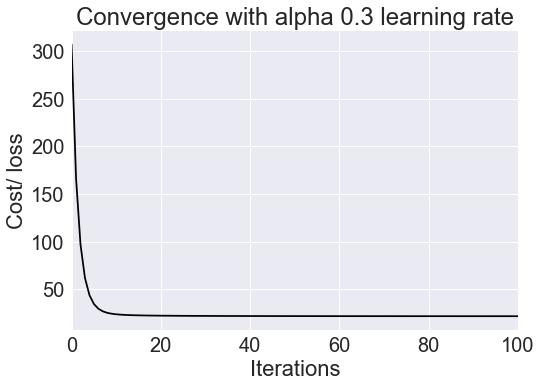

In [29]:
# Plot cost compared to number of iterations
plt.title("Convergence with alpha 0.3 learning rate");
plt.plot(cost_grad,color='black', label="0.3");
plt.ylabel('Cost/ loss');
plt.xlabel('Iterations');
plt.xlim(0,100);

# Compare cost/loss of the methods

In [30]:
print("Mean squared error sci-kit learn: ",mean_squared_error(y,y_pred_ridge))
print("Mean squared error normal equation: ",np.mean(np.square(y_pred2_ridge-y)))
print("Mean squared error gradient descent: ",cost_grad[-1])

Mean squared error sci-kit learn:  21.8980429263
Mean squared error normal equation:  21.8980429263
Mean squared error gradient descent:  21.8980429263
